In [3]:
%matplotlib widget
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from pruning_sb3.pruning_gym.pruning_env import PruningEnv
from pruning_sb3.pruning_gym.models import *
import numpy as np
import cv2
import random
import argparse
from pruning_sb3.args.args import args
from pruning_sb3.pruning_gym.helpers import linear_schedule, exp_schedule, optical_flow_create_shared_vars, \
    set_args, organize_args, add_arg_to_env
import multiprocessing as mp
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Create the ArgumentParser object
parser = argparse.ArgumentParser()
set_args(args, parser)
args, unknown = parser.parse_known_args()
parsed_args = vars(args)
print(args)
parsed_args_dict = organize_args(parsed_args)


Namespace(args_callback_eval_freq=4000, args_callback_n_eval_episodes=40, args_env_movement_reward_scale=5, args_env_distance_reward_scale=0, args_env_condition_reward_scale=0, args_env_terminate_reward_scale=0.4, args_env_collision_reward_scale=-0.005, args_env_slack_reward_scale=-0.01, args_env_pointing_orientation_reward_scale=2, args_env_perpendicular_orientation_reward_scale=3, args_env_max_steps=100, args_env_use_ik=True, args_env_action_scale=0.1, args_env_action_dim=6, args_train_name='trainenv', args_train_tree_urdf_path='./meshes_and_urdf/urdf/trees/envy/train', args_train_tree_obj_path='./meshes_and_urdf/meshes/trees/envy/train', args_train_tree_labelled_path='./meshes_and_urdf/meshes/trees/envy/train_labelled', args_train_renders=False, args_train_curriculum_distances=(0.8,), args_train_curriculum_level_steps=(), args_train_tree_count=100, args_test_tree_urdf_path='./meshes_and_urdf/urdf/trees/envy/test', args_test_tree_obj_path='./meshes_and_urdf/meshes/trees/envy/test', a

In [45]:
def create_bins(num_latitude_bins, num_longitude_bins):
    """
    Create bins separated by 10 degrees on a unit sphere.

    Parameters:
        num_latitude_bins (int): Number of bins along the latitude direction.
        num_longitude_bins (int): Number of bins along the longitude direction.

    Returns:
        list of tuples: List of tuples where each tuple represents a bin defined by
                        (latitude_min, latitude_max, longitude_min, longitude_max).
    """
    bin_size = np.deg2rad(10)  # Convert degrees to radians
    offset = np.deg2rad(1)
    bins = []
    for i in range(num_latitude_bins):
        lat_min = -np.pi / 2 + i * bin_size
        lat_max = -np.pi / 2 + (i + 1) * bin_size +offset
        for j in range(num_longitude_bins):
            lon_min = -np.pi + j * bin_size
            lon_max = -np.pi + (j + 1) * bin_size
            bins.append((lat_min, lat_max, lon_min, lon_max))

    return bins


def angle_between_vectors(v1, v2):
    """
    Calculate the angle in radians between two vectors.

    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.

    Returns:
        float: Angle in radians between the two vectors.
    """
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


def populate_bins(direction_vectors, bins):
    """
    Populate the bins based on a list of direction vectors.

    Parameters:
        direction_vectors (list of numpy.ndarray): List of direction vectors.
        bins (list of tuples): List of bins where each tuple represents a bin defined by
                               (latitude_min, latitude_max, longitude_min, longitude_max).

    Returns:
        list of lists: List of lists where each sublist represents the indices of direction vectors
                       assigned to the corresponding bin.
    """
    bin_assignments = [[] for _ in range(len(bins))]

    for i, direction_vector in enumerate(direction_vectors):
      
        lat_angle = np.arcsin(direction_vector[2])
        lon_angle = np.arctan2(direction_vector[1], direction_vector[0])
      
        # Find the closest bin based on latitude and longitude angles
        
        min_dist = float('inf')
        closest_bin_idx = None
        for j, bin_ in enumerate(bins):
            lat_min, lat_max, lon_min, lon_max = bin_
            if lat_min <= lat_angle <= lat_max and lon_min <= lon_angle <= lon_max:
                dist = angle_between_vectors(direction_vector,
                                             (np.sin((lat_min + lat_max) / 2), 0, np.cos((lat_min + lat_max) / 2)))
                if dist < min_dist:
                    min_dist = dist
                    closest_bin_idx = j

        # Assign the direction vector to the closest bin
        bin_assignments[closest_bin_idx].append(i)

    return bin_assignments

def create_bins(num_latitude_bins, num_longitude_bins):
    """
    Create bins on the unit sphere with equal area.
    
    Parameters:
        num_latitude_bins (int): Number of bins along the latitude direction.
        num_longitude_bins (int): Number of bins along the longitude direction.
    
    Returns:
        list of tuples: List of tuples where each tuple represents a bin defined by
                        (latitude_min, latitude_max, longitude_min, longitude_max).
    """
    bins = []
    offset = np.deg2rad(1)
    
    for i in range(num_latitude_bins):
        lat_min = -np.pi/2 + (i * np.pi / num_latitude_bins)
        lat_max = -np.pi/2 + ((i + 1) * np.pi / num_latitude_bins)
       
        for j in range(num_longitude_bins):
            lon_min = -np.pi + (j * 2 * np.pi / num_longitude_bins)
            lon_max = -np.pi + ((j + 1) * 2 * np.pi / num_longitude_bins)
            
            bins.append((lat_min, lat_max, lon_min, lon_max))
    
    return bins

def visualize_sphere(bins, bin_assignments, direction_vectors):
    """
    Visualize the unit sphere with bin color representing the frequency of direction vectors.
    
    Parameters:
        bins (list of tuples): List of bins where each tuple represents a bin defined by
                               (latitude_min, latitude_max, longitude_min, longitude_max).
        bin_assignments (list of lists): List of lists where each sublist represents the indices of direction vectors
                                          assigned to the corresponding bin.
        direction_vectors (list of numpy.ndarray): List of direction vectors.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Compute colors
    frequencies = [np.log(len(bin_assignment)+1) for bin_assignment in bin_assignments]
    norm = plt.Normalize(vmin=min(frequencies), vmax=max(frequencies))
    cmap = plt.cm.viridis
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i, bin_ in enumerate(bins):
        lat_min, lat_max, lon_min, lon_max = bin_
        color = scalar_map.to_rgba(frequencies[i])
        
        # Draw rectangle on the sphere
        u = np.linspace(lon_min, lon_max, 10)
        v = np.linspace(lat_min, lat_max, 10)
        x = np.outer(np.cos(u), np.cos(v))
        y = np.outer(np.sin(u), np.cos(v))
        z = np.outer(np.ones(np.size(u)), np.sin(v))
        ax.plot_surface(x, y, z, color=color, alpha=1)
    
    # Plot direction vectors
    direction_vectors = np.array(direction_vectors)
    # ax.quiver(0, 0, 0, direction_vectors[:, 0], direction_vectors[:, 1], direction_vectors[:, 2], color='red')
    
    ax.set_xlabel('X - Branch direction')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Up')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    cax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    fig.colorbar(scalar_map, cax=cax, orientation='vertical')
    scalar_map.set_array(frequencies)
    plt.show()
    
    
def visualize_2d(bins, bin_assignments):
    # Extract latitude and longitude ranges from each bin
    lat_ranges, lon_ranges = zip(*[((lat_min, lat_max), (lon_min, lon_max)) for lat_min, lat_max, lon_min, lon_max in bins])
    
    # Calculate bin centers
    lat_centers = [(lat_min + lat_max) / 2 for lat_min, lat_max in lat_ranges]
    lon_centers = [(lon_min + lon_max) / 2 for lon_min, lon_max in lon_ranges]
    
    # Flatten bin assignments to get frequencies
    frequencies = [len(bin_assignment)+1 for bin_assignment in bin_assignments]
    
    # Convert to numpy arrays for hist2d
    lat_centers = np.array(lat_centers)
    lon_centers = np.array(lon_centers)
    frequencies = np.array(frequencies)
    
    # Create 2D histogram
    figure = plt.figure()
    plt.hist2d(lat_centers, lon_centers, weights=frequencies, bins=[num_latitude_bins, num_longitude_bins], norm=LogNorm())
    plt.colorbar(label='Frequency')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Frequency of orientation in bin')
    plt.show()

In [42]:

args_test = dict(parsed_args_dict['args_env'], **parsed_args_dict['args_train'])
args_test['tree_obj_path'] = '../meshes_and_urdf/meshes/trees/envy/train'
args_test['tree_urdf_path']='../meshes_and_urdf/urdf/trees/envy/train'
args_test['tree_labelled_path'] = '../meshes_and_urdf/meshes/trees/envy/train_labelled'
args_test['tree_count'] = 150
env = PruningEnv(**args_test, make_trees=True)
#get all trees and points
point_list = []
for i in env.trees:
    point_list.extend(i.curriculum_points[0])

orientations = [np.array(i[1][1])/np.linalg.norm(np.array(i[1][1])) for i in point_list]
# orientations = np.array(orientations) / np.linalg.norm(orientations, axis=1)[:, np.newaxis]



None
../meshes_and_urdf/urdf/trees/envy/train\tree_1.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_1.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_1.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_1_points.pkl
Number of points:  7138
Position:  [-0.04311044 -0.61945538 -0.13379807] Orientation:  [0 0 0 1]
Number of reachable points:  56
Number of reachable points:  56
Curriculum level:  0 Number of points:  56
../meshes_and_urdf/urdf/trees/envy/train\tree_10.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_10.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_10.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_10_points.pkl
Number of points:  7167
Position:  [-0.01782156 -0.59518214 -0.03806993] Orientation:  [0 0 0 1]
Number of reachable points:  82
Number of reachable points:  82
Curriculum level:  0 Number of points:  82
../meshes_and_urdf/urdf/trees/envy/train\tree_100.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_100.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_100.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_100_points.pkl
Number of points:  8339
Position:  [ 0.11941688 -0.57216483 -0.07923644] Orientation:  [0 0 0 1]
Number of reachable points:  352
Number of reachable points:  352
Curriculum level:  0 Number of points:  352
../meshes_and_urdf/urdf/trees/envy/train\tree_101.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_101.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_101.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_101_points.pkl
Number of points:  8339
Position:  [ 0.12366036 -0.56914777 -0.1119745 ] Orientation:  [0 0 0 1]
Number of reachable points:  364
Number of reachable points:  364
Curriculum level:  0 Number of points:  364
../meshes_and_urdf/urdf/trees/envy/train\tree_102.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_102.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_102.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_102_points.pkl
Number of points:  8339
Position:  [ 0.00115182 -0.55537768 -0.0625907 ] Orientation:  [0 0 0 1]
Number of reachable points:  427
Number of reachable points:  427
Curriculum level:  0 Number of points:  427
../meshes_and_urdf/urdf/trees/envy/train\tree_103.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_103.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_103.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_103_points.pkl
Number of points:  8339
Position:  [ 0.04703374 -0.57530335 -0.03453102] Orientation:  [0 0 0 1]
Number of reachable points:  347
Number of reachable points:  347
Curriculum level:  0 Number of points:  347
../meshes_and_urdf/urdf/trees/envy/train\tree_104.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_104.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_104.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_104_points.pkl
Number of points:  8339
Position:  [ 0.03991594 -0.56125988  0.04938654] Orientation:  [0 0 0 1]
Number of reachable points:  424
Number of reachable points:  424
Curriculum level:  0 Number of points:  424
../meshes_and_urdf/urdf/trees/envy/train\tree_105.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_105.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_105.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_105_points.pkl
Number of points:  8339
Position:  [ 0.01228585 -0.57774885  0.19559047] Orientation:  [0 0 0 1]
Number of reachable points:  232
Number of reachable points:  232
Curriculum level:  0 Number of points:  232
../meshes_and_urdf/urdf/trees/envy/train\tree_106.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_106.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_106.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_106_points.pkl
Number of points:  8339
Position:  [ 0.03489681 -0.57734783  0.15634025] Orientation:  [0 0 0 1]
Number of reachable points:  287
Number of reachable points:  287
Curriculum level:  0 Number of points:  287
../meshes_and_urdf/urdf/trees/envy/train\tree_107.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_107.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_107.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_107_points.pkl
Number of points:  8339
Position:  [-0.01072253 -0.55671181  0.23655148] Orientation:  [0 0 0 1]
Number of reachable points:  322
Number of reachable points:  322
Curriculum level:  0 Number of points:  322
../meshes_and_urdf/urdf/trees/envy/train\tree_108.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_108.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_108.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_108_points.pkl
Number of points:  8339
Position:  [ 0.07620069 -0.56503958  0.37081489] Orientation:  [0 0 0 1]
Number of reachable points:  222
Number of reachable points:  222
Curriculum level:  0 Number of points:  222
../meshes_and_urdf/urdf/trees/envy/train\tree_109.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_109.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_109.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_109_points.pkl
Number of points:  8339
Position:  [ 0.21938122 -0.56040106  0.32346853] Orientation:  [0 0 0 1]
Number of reachable points:  361
Number of reachable points:  361
Curriculum level:  0 Number of points:  361
../meshes_and_urdf/urdf/trees/envy/train\tree_11.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_11.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_11.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_11_points.pkl
Number of points:  7547
Position:  [ 0.1816812  -0.57531441  0.19507831] Orientation:  [0 0 0 1]
Number of reachable points:  552
Number of reachable points:  552
Curriculum level:  0 Number of points:  552
../meshes_and_urdf/urdf/trees/envy/train\tree_110.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_110.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_110.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_110_points.pkl
Number of points:  8339
Position:  [ 0.28409321 -0.56584308  0.05988193] Orientation:  [0 0 0 1]
Number of reachable points:  488
Number of reachable points:  488
Curriculum level:  0 Number of points:  488
../meshes_and_urdf/urdf/trees/envy/train\tree_111.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_111.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_111.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_111_points.pkl
Number of points:  8339
Position:  [ 0.16343461 -0.57105845  0.03889906] Orientation:  [0 0 0 1]
Number of reachable points:  414
Number of reachable points:  414
Curriculum level:  0 Number of points:  414
../meshes_and_urdf/urdf/trees/envy/train\tree_112.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_112.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_112.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_112_points.pkl
Number of points:  8339
Position:  [ 0.1799424  -0.58265611 -0.0331313 ] Orientation:  [0 0 0 1]
Number of reachable points:  346
Number of reachable points:  346
Curriculum level:  0 Number of points:  346
../meshes_and_urdf/urdf/trees/envy/train\tree_113.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_113.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_113.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_113_points.pkl
Number of points:  8339
Position:  [ 0.21722481 -0.56274242 -0.12494176] Orientation:  [0 0 0 1]
Number of reachable points:  489
Number of reachable points:  489
Curriculum level:  0 Number of points:  489
../meshes_and_urdf/urdf/trees/envy/train\tree_114.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_114.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_114.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_114_points.pkl
Number of points:  8339
Position:  [ 0.20039939 -0.56040442  0.02027455] Orientation:  [0 0 0 1]
Number of reachable points:  491
Number of reachable points:  491
Curriculum level:  0 Number of points:  491
../meshes_and_urdf/urdf/trees/envy/train\tree_115.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_115.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_115.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_115_points.pkl
Number of points:  8339
Position:  [ 0.05698453 -0.57289962 -0.12170184] Orientation:  [0 0 0 1]
Number of reachable points:  345
Number of reachable points:  345
Curriculum level:  0 Number of points:  345
../meshes_and_urdf/urdf/trees/envy/train\tree_116.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_116.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_116.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_116_points.pkl
Number of points:  8339
Position:  [ 0.18249627 -0.55651124 -0.12151461] Orientation:  [0 0 0 1]
Number of reachable points:  473
Number of reachable points:  473
Curriculum level:  0 Number of points:  473
../meshes_and_urdf/urdf/trees/envy/train\tree_117.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_117.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_117.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_117_points.pkl
Number of points:  8339
Position:  [ 0.22024101 -0.55389609 -0.20486561] Orientation:  [0 0 0 1]
Number of reachable points:  659
Number of reachable points:  659
Curriculum level:  0 Number of points:  659
../meshes_and_urdf/urdf/trees/envy/train\tree_118.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_118.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_118.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_118_points.pkl
Number of points:  8339
Position:  [ 0.1125735  -0.56355286 -0.31296044] Orientation:  [0 0 0 1]
Number of reachable points:  509
Number of reachable points:  509
Curriculum level:  0 Number of points:  509
../meshes_and_urdf/urdf/trees/envy/train\tree_119.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_119.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_119.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_119_points.pkl
Number of points:  8339
Position:  [ 0.00817296 -0.55101392 -0.28425855] Orientation:  [0 0 0 1]
Number of reachable points:  589
Number of reachable points:  589
Curriculum level:  0 Number of points:  589
../meshes_and_urdf/urdf/trees/envy/train\tree_12.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_12.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_12.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_12_points.pkl
Number of points:  7831
Position:  [ 0.02360142 -0.57371613 -0.30180353] Orientation:  [0 0 0 1]
Number of reachable points:  136
Number of reachable points:  136
Curriculum level:  0 Number of points:  136
../meshes_and_urdf/urdf/trees/envy/train\tree_120.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_120.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_120.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_120_points.pkl
Number of points:  8339
Position:  [ 0.07932644 -0.58888588 -0.35557496] Orientation:  [0 0 0 1]
Number of reachable points:  331
Number of reachable points:  331
Curriculum level:  0 Number of points:  331
../meshes_and_urdf/urdf/trees/envy/train\tree_121.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_121.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_121.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_121_points.pkl
Number of points:  8339
Position:  [-0.00974494 -0.59978939 -0.20692719] Orientation:  [0 0 0 1]
Number of reachable points:  241
Number of reachable points:  241
Curriculum level:  0 Number of points:  241
../meshes_and_urdf/urdf/trees/envy/train\tree_122.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_122.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_122.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_122_points.pkl
Number of points:  8339
Position:  [-0.05291787 -0.60461633 -0.21358356] Orientation:  [0 0 0 1]
Number of reachable points:  204
Number of reachable points:  204
Curriculum level:  0 Number of points:  204
../meshes_and_urdf/urdf/trees/envy/train\tree_123.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_123.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_123.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_123_points.pkl
Number of points:  8339
Position:  [-0.04583316 -0.59580708 -0.3315128 ] Orientation:  [0 0 0 1]
Number of reachable points:  327
Number of reachable points:  327
Curriculum level:  0 Number of points:  327
../meshes_and_urdf/urdf/trees/envy/train\tree_124.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_124.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_124.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_124_points.pkl
Number of points:  8339
Position:  [ 0.05241091 -0.580499   -0.47684928] Orientation:  [0 0 0 1]
Number of reachable points:  362
Number of reachable points:  362
Curriculum level:  0 Number of points:  362
../meshes_and_urdf/urdf/trees/envy/train\tree_125.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_125.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_125.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_125_points.pkl
Number of points:  8339
Position:  [-0.07243487 -0.60491926 -0.52457108] Orientation:  [0 0 0 1]
Number of reachable points:  385
Number of reachable points:  385
Curriculum level:  0 Number of points:  385
../meshes_and_urdf/urdf/trees/envy/train\tree_126.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_126.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_126.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_126_points.pkl
Number of points:  8339
Position:  [-0.21496287 -0.58248194 -0.61084757] Orientation:  [0 0 0 1]
Number of reachable points:  634
Number of reachable points:  634
Curriculum level:  0 Number of points:  634
../meshes_and_urdf/urdf/trees/envy/train\tree_127.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_127.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_127.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_127_points.pkl
Number of points:  8339
Position:  [-0.07369302 -0.56679353 -0.61413157] Orientation:  [0 0 0 1]
Number of reachable points:  679
Number of reachable points:  679
Curriculum level:  0 Number of points:  679
../meshes_and_urdf/urdf/trees/envy/train\tree_128.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_128.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_128.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_128_points.pkl
Number of points:  8339
Position:  [-0.07999709 -0.57138536 -0.69231713] Orientation:  [0 0 0 1]
Number of reachable points:  678
Number of reachable points:  678
Curriculum level:  0 Number of points:  678
../meshes_and_urdf/urdf/trees/envy/train\tree_129.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_129.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_129.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_129_points.pkl
Number of points:  8339
Position:  [-0.14119366 -0.55005363 -0.64342755] Orientation:  [0 0 0 1]
Number of reachable points:  747
Number of reachable points:  747
Curriculum level:  0 Number of points:  747
../meshes_and_urdf/urdf/trees/envy/train\tree_13.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_13.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_13.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_13_points.pkl
Number of points:  6926
Position:  [-0.0535713  -0.56097191 -0.55990239] Orientation:  [0 0 0 1]
Number of reachable points:  289
Number of reachable points:  289
Curriculum level:  0 Number of points:  289
../meshes_and_urdf/urdf/trees/envy/train\tree_130.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_130.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_130.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_130_points.pkl
Number of points:  8339
Position:  [-0.01574298 -0.58254686 -0.59221083] Orientation:  [0 0 0 1]
Number of reachable points:  504
Number of reachable points:  504
Curriculum level:  0 Number of points:  504
../meshes_and_urdf/urdf/trees/envy/train\tree_131.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_131.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_131.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_131_points.pkl
Number of points:  8339
Position:  [-0.05039266 -0.60579879 -0.54333111] Orientation:  [0 0 0 1]
Number of reachable points:  363
Number of reachable points:  363
Curriculum level:  0 Number of points:  363
../meshes_and_urdf/urdf/trees/envy/train\tree_132.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_132.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_132.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_132_points.pkl
Number of points:  8339
Position:  [-0.08267569 -0.62869824 -0.45868359] Orientation:  [0 0 0 1]
Number of reachable points:  234
Number of reachable points:  234
Curriculum level:  0 Number of points:  234
../meshes_and_urdf/urdf/trees/envy/train\tree_133.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_133.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_133.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_133_points.pkl
Number of points:  8339
Position:  [-0.2068095  -0.64912382 -0.48417308] Orientation:  [0 0 0 1]
Number of reachable points:  206
Number of reachable points:  206
Curriculum level:  0 Number of points:  206
../meshes_and_urdf/urdf/trees/envy/train\tree_134.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_134.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_134.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_134_points.pkl
Number of points:  8339
Position:  [-0.12305781 -0.65662288 -0.36499369] Orientation:  [0 0 0 1]
Number of reachable points:  74
Number of reachable points:  74
Curriculum level:  0 Number of points:  74
../meshes_and_urdf/urdf/trees/envy/train\tree_135.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_135.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_135.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_135_points.pkl
Number of points:  8339
Position:  [-0.10290468 -0.63667195 -0.37654168] Orientation:  [0 0 0 1]
Number of reachable points:  125
Number of reachable points:  125
Curriculum level:  0 Number of points:  125
../meshes_and_urdf/urdf/trees/envy/train\tree_136.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_136.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_136.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_136_points.pkl
Number of points:  8339
Position:  [ 0.01179374 -0.65751383 -0.30951354] Orientation:  [0 0 0 1]
Number of reachable points:  46
Number of reachable points:  46
Curriculum level:  0 Number of points:  46
../meshes_and_urdf/urdf/trees/envy/train\tree_137.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_137.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_137.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_137_points.pkl
Number of points:  8339
Position:  [-0.12327052 -0.67068292 -0.38004661] Orientation:  [0 0 0 1]
Number of reachable points:  46
Number of reachable points:  46
Curriculum level:  0 Number of points:  46
../meshes_and_urdf/urdf/trees/envy/train\tree_138.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_138.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_138.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_138_points.pkl
Number of points:  8339
Position:  [-0.13868204 -0.67165692 -0.34948345] Orientation:  [0 0 0 1]
Number of reachable points:  62
Number of reachable points:  62
Curriculum level:  0 Number of points:  62
../meshes_and_urdf/urdf/trees/envy/train\tree_139.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_139.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_139.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_139_points.pkl
Number of points:  8339
Position:  [-0.25620203 -0.65963508 -0.47185483] Orientation:  [0 0 0 1]
Number of reachable points:  170
Number of reachable points:  170
Curriculum level:  0 Number of points:  170
../meshes_and_urdf/urdf/trees/envy/train\tree_14.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_14.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_14.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_14_points.pkl
Number of points:  7432
Position:  [-0.22263565 -0.64343378 -0.61521462] Orientation:  [0 0 0 1]
Number of reachable points:  78
Number of reachable points:  78
Curriculum level:  0 Number of points:  78
../meshes_and_urdf/urdf/trees/envy/train\tree_140.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_140.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_140.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_140_points.pkl
Number of points:  8339
Position:  [-0.15581607 -0.66513856 -0.49798616] Orientation:  [0 0 0 1]
Number of reachable points:  99
Number of reachable points:  99
Curriculum level:  0 Number of points:  99
../meshes_and_urdf/urdf/trees/envy/train\tree_141.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_141.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_141.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_141_points.pkl
Number of points:  8339
Position:  [-0.21152783 -0.6833939  -0.52246117] Orientation:  [0 0 0 1]
Number of reachable points:  109
Number of reachable points:  109
Curriculum level:  0 Number of points:  109
../meshes_and_urdf/urdf/trees/envy/train\tree_142.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_142.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_142.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_142_points.pkl
Number of points:  8339
Position:  [-0.33487271 -0.68442717 -0.38663245] Orientation:  [0 0 0 1]
Number of reachable points:  155
Number of reachable points:  155
Curriculum level:  0 Number of points:  155
../meshes_and_urdf/urdf/trees/envy/train\tree_143.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_143.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_143.obj


Unimplemented OBJ format statement 's' on line 's 1'


Loaded points from pickle file  ./pkl/trees/tree_143_points.pkl
Number of points:  8339
Position:  [-0.4800939  -0.67739938 -0.34168904] Orientation:  [0 0 0 1]
Number of reachable points:  184
Number of reachable points:  184
Curriculum level:  0 Number of points:  184
../meshes_and_urdf/urdf/trees/envy/train\tree_144.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_144.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_144.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66050
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_144_points.pkl
Number of points:  8339
Position:  [ 1.07375891 -0.4506803  -0.41001318] Orientation:  [0 0 0 1]
Number of reachable points:  924
Number of reachable points:  924
Curriculum level:  0 Number of points:  924
../meshes_and_urdf/urdf/trees/envy/train\tree_145.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_145.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_145.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66060
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_145_points.pkl
Number of points:  8339
Position:  [ 1.16352836 -0.43207835 -0.34830398] Orientation:  [0 0 0 1]
Number of reachable points:  992
Number of reachable points:  992
Curriculum level:  0 Number of points:  992
../meshes_and_urdf/urdf/trees/envy/train\tree_146.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_146.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_146.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66026
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_146_points.pkl
Number of points:  8339
Position:  [ 1.12969377 -0.44584187 -0.3154132 ] Orientation:  [0 0 0 1]
Number of reachable points:  976
Number of reachable points:  976
Curriculum level:  0 Number of points:  976
../meshes_and_urdf/urdf/trees/envy/train\tree_147.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_147.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_147.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66033
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_147_points.pkl
Number of points:  8339
Position:  [ 1.04327803 -0.45901697 -0.36578457] Orientation:  [0 0 0 1]
Number of reachable points:  930
Number of reachable points:  930
Curriculum level:  0 Number of points:  930
../meshes_and_urdf/urdf/trees/envy/train\tree_148.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_148.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_148.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66053
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_148_points.pkl
Number of points:  8339
Position:  [ 0.96534341 -0.44400001 -0.26556053] Orientation:  [0 0 0 1]
Number of reachable points:  1076
Number of reachable points:  1076
Curriculum level:  0 Number of points:  1076
../meshes_and_urdf/urdf/trees/envy/train\tree_149.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_149.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_149.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66031
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_149_points.pkl
Number of points:  8339
Position:  [ 1.07211357 -0.45575996 -0.13343152] Orientation:  [0 0 0 1]
Number of reachable points:  1065
Number of reachable points:  1065
Curriculum level:  0 Number of points:  1065
../meshes_and_urdf/urdf/trees/envy/train\tree_15.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_15.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_15.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  77177
Number of points after filtering:  9543
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_15_points.pkl
Number of points:  9543
Position:  [ 0.92639347 -0.46177178 -0.2822252 ] Orientation:  [0 0 0 1]
Number of reachable points:  1372
Number of reachable points:  1372
Curriculum level:  0 Number of points:  1372
../meshes_and_urdf/urdf/trees/envy/train\tree_150.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_150.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_150.obj


Unimplemented OBJ format statement 's' on line 's 1'


Number of points before filtering:  66032
Number of points after filtering:  8339
Saved points to pickle file  ../meshes_and_urdf/urdf/trees/envy/train\tree_150_points.pkl
Number of points:  8339
Position:  [ 0.98665759 -0.46616085 -0.19817214] Orientation:  [0 0 0 1]
Number of reachable points:  1030
Number of reachable points:  1030
Curriculum level:  0 Number of points:  1030
../meshes_and_urdf/urdf/trees/envy/train\tree_151.urdf ../meshes_and_urdf/meshes/trees/envy/train\tree_151.obj ../meshes_and_urdf/meshes/trees/envy/train_labelled\tree_151.obj


Unimplemented OBJ format statement 's' on line 's 1'


KeyboardInterrupt: 

In [16]:
import os, glob, pickle
import numpy as np
reachable_points = []
pkl_path = '../pkl/envy'
glob_path = os.path.join(pkl_path, '*.pkl')
for pkl_path in glob.glob(glob_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
        reachable_points.extend(data[2])
reachable_points = [np.array(i[1])/(np.linalg.norm(np.array(i[1]))+1e-5) for i in reachable_points]

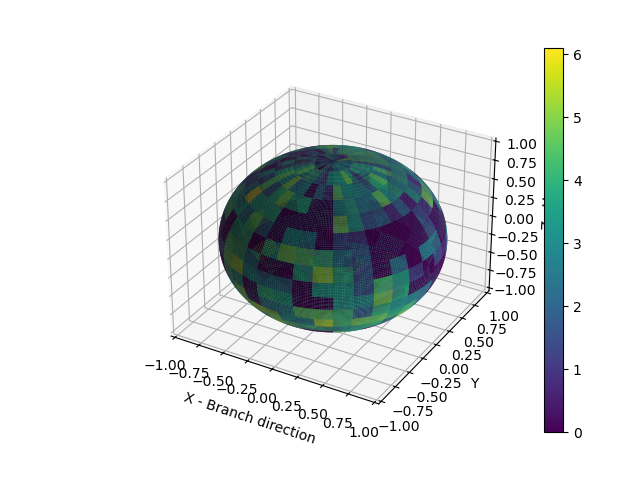

In [43]:

num_latitude_bins = 18  # 90 degrees / 10 degrees per bin = 9 bins
num_longitude_bins = 36  # 360 degrees / 10 degrees per bin = 36 bins
bins = create_bins(num_latitude_bins, num_longitude_bins)

bin_assignments_orientation = populate_bins(orientations, bins)
visualize_sphere(bins, bin_assignments_orientation, orientations)


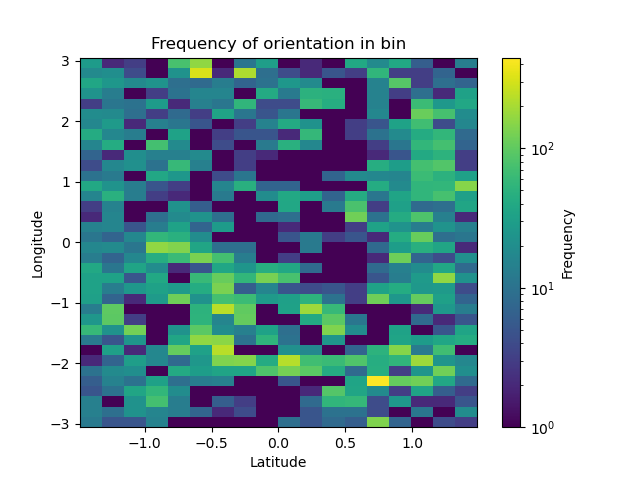

In [47]:
visualize_2d(bins, bin_assignments_orientation)

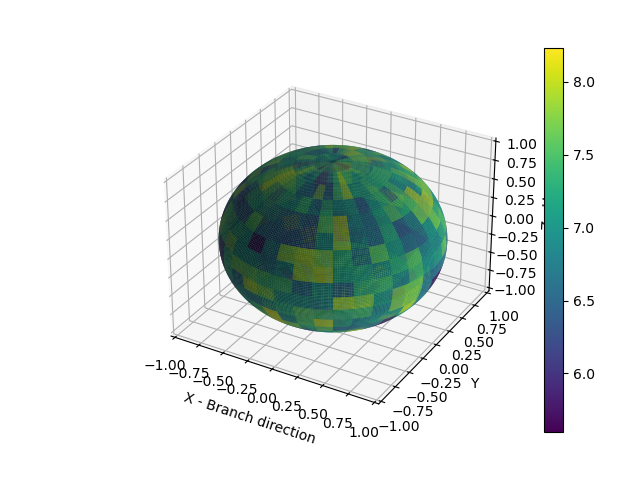

In [38]:
num_latitude_bins = 18  # 90 degrees / 10 degrees per bin = 9 bins
num_longitude_bins = 36  # 360 degrees / 10 degrees per bin = 36 bins
bins = create_bins(num_latitude_bins, num_longitude_bins)

bin_assignments_reachable = populate_bins(reachable_points, bins)
visualize_sphere(bins, bin_assignments_reachable, reachable_points)


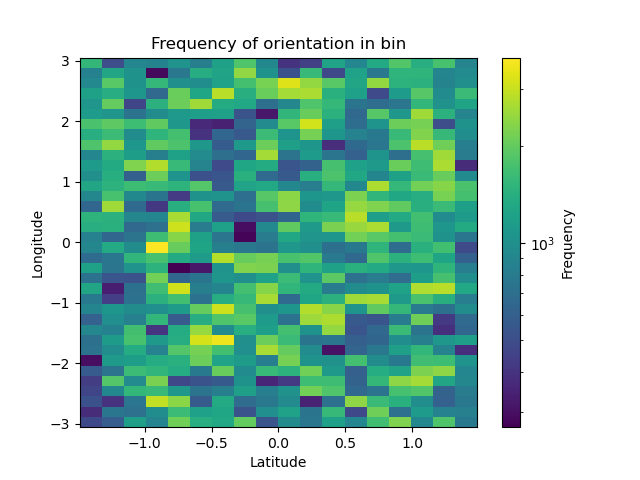

In [41]:
visualize_2d(bins, bin_assignments_reachable)

In [20]:
frequencies = [len(bin_assignment) for bin_assignment in bin_assignments_reachable]
print(min(frequencies), max(frequencies))

269 3763


In [27]:
frequencies = [len(bin_assignment) for bin_assignment in bin_assignments_orientation]
print(min(frequencies), max(frequencies))

0 446


In [1]:
#I want to bin euclidean space with resolution of 5cm. The euclidean space is a semi-sphere with radius 1m centered at the origin.
# The radius of the sphere is 0.95m, and the semisphere is 45 degrees in the z direction.
# The bins are defined by the center of the bin. Can you help me with this?



In [30]:

# Define the radius and resolution
radius = 0.95  # in meters
resolution = 0.05  # in meters

# Calculate the number of bins in each direction
num_bins = int(radius / resolution)*2

# Create a 3D array to represent the bins
bins = np.zeros((num_bins, num_bins, num_bins))

# Calculate the centers of the bins
centers = np.zeros((num_bins, num_bins, num_bins, 3))
for i in range(-num_bins//2, num_bins//2):
    for j in range(-num_bins//2, num_bins//2):
        for k in range(-num_bins//2, num_bins//2):
            # Calculate the center of the bin
            centers[i, j, k] = [(i + 0.5) * resolution, (j + 0.5) * resolution, (k + 0.5) * resolution]

# Filter out the bins that are outside the semi-sphere or below the 45-degree line in the z direction
valid_centers = []
for i in range(-num_bins//2, num_bins//2):
    for j in range(-num_bins//2, num_bins//2):
        for k in range(-num_bins//2, num_bins//2):
            x, y, z = centers[i, j, k]
            if x**2 + y**2 + z**2 <= radius**2 and y < -0.7:#and z <= np.tan(np.radians(45)) * np.sqrt(x**2 + y**2):
                valid_centers.append((x, y, z))

valid_centers = np.array(valid_centers)
print(valid_centers)

[[-0.575 -0.725 -0.175]
 [-0.575 -0.725 -0.125]
 [-0.575 -0.725 -0.075]
 ...
 [ 0.575 -0.725  0.075]
 [ 0.575 -0.725  0.125]
 [ 0.575 -0.725  0.175]]


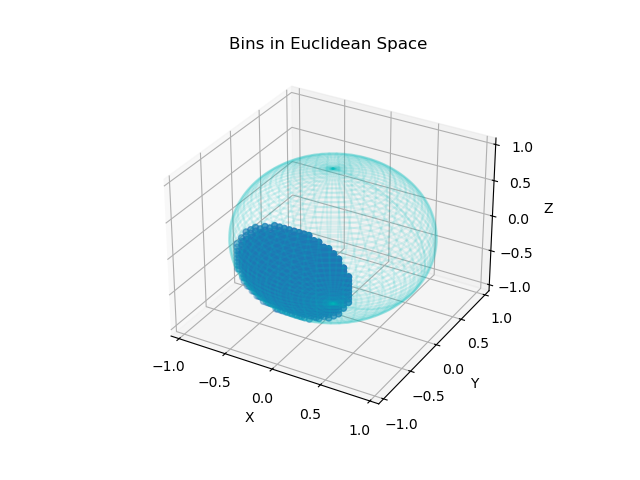

In [29]:

fig = plt.figure()

# Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the centers of the valid bins
ax.scatter(valid_centers[:, 0], valid_centers[:, 1], valid_centers[:, 2])

# Create a wireframe sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='c', alpha=0.1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Bins in Euclidean Space')

# Show the plot
plt.show()